# Rug Pull Detection — Notebook de Experimentación

**Objetivo:** Explorar los datos, construir features y entrenar 3 modelos de clasificación para detectar rug pulls en pools Uniswap V2.

**Pipeline:**
1. Carga de datos desde la Batch API (todos los 12 meses)
2. Exploración con `ydata_profiling`
3. Feature engineering + heurísticas de labeling
4. Entrenamiento con Random Forest, XGBoost y LightGBM
5. Registro de experimentos en MLflow → MinIO

**Servicios:** Jupyter corre en Docker (`net_mlops`). La Batch API corre en el host.

| Servicio | URL desde este notebook |
|---|---|
| Batch API | `http://host.docker.internal:8000` |
| MLflow | `http://mlflow:5000` |
| MinIO (S3) | `http://minio:9000` |

---
## Panel 0 — Imports y configuración global

In [1]:
import os
import warnings
from collections import defaultdict
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
pd.set_option('display.float_format', '{:.6f}'.format)

print('✓ Imports OK')

✓ Imports OK


In [2]:
# ── Configuración global

# Servicios
API_URL     = 'http://host.docker.internal:8000'
MLFLOW_URI  = 'http://mlflow:5000'
MINIO_URL   = 'http://minio:9000'

# Credenciales MinIO
os.environ['MLFLOW_S3_ENDPOINT_URL'] = MINIO_URL
os.environ['AWS_ACCESS_KEY_ID']      = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY']  = 'supersecret'

# Constantes del dominio
WETH         = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
ETH_ADDRESS  = '0x0000000000000000000000000000000000000000'
DEAD_ADDRESS = '0x000000000000000000000000000000000000dead'

WINDOW     = 6646      # bloques ≈ 24h de observación
BLOCKSTUDY = 13220488  # bloque de corte para labeling
INACTIVITY = 160000    # bloques sin actividad = pool abandonado

# Features del modelo
FEATURES = [
    'n_syncs', 'WETH', 'prices', 'liquidity',
    'num_transactions', 'n_unique_addresses',
    'tx_curve', 'mints', 'burns', 'difference_token_pool'
]

RANDOM_STATE = 42

print('✓ Configuración OK')
print(f'  API     : {API_URL}')
print(f'  MLflow  : {MLFLOW_URI}')
print(f'  MinIO   : {MINIO_URL}')

✓ Configuración OK
  API     : http://host.docker.internal:8000
  MLflow  : http://mlflow:5000
  MinIO   : http://minio:9000


---
## Panel 1 — Carga de datos desde la Batch API

Cargamos los 12 batches mensuales y los consolidamos en 4 DataFrames globales.
Usamos `GET /batch/{id}` para no alterar el puntero del ciclo.

In [3]:
def check_api():
    """Verifica que la API esté disponible y el ciclo inicializado."""
    try:
        r = requests.get(f'{API_URL}/status', timeout=10)
        r.raise_for_status()
        data = r.json()
        if not data.get('initialized'):
            print('API no inicializada. Ejecutando /init...')
            requests.post(f'{API_URL}/init', timeout=300).raise_for_status()
            print('✓ Inicializada')
        else:
            n = data.get('num_batches', 12)
            print(f'✓ API OK — {n} batches disponibles')
            print(f'  Rango: {data["date_min"]} → {data["date_max"]}')
    except Exception as e:
        raise RuntimeError(f'No se puede conectar a la API ({API_URL}): {e}')

check_api()

✓ API OK — 12 batches disponibles
  Rango: 2020-06-24 → 2021-10-16


In [4]:
def load_all_batches(n_batches: int = 12) -> tuple:
    """
    Carga los n_batches mensuales desde la API y los consolida.
    Retorna (df_pools, df_events, df_metadata, df_transfers).
    """
    all_pools, all_events, all_metadata, all_transfers = [], [], [], []

    for batch_id in range(1, n_batches + 1):
        print(f'  Cargando batch {batch_id:2d}/{n_batches}...', end=' ')
        r = requests.get(f'{API_URL}/batch/{batch_id}', timeout=600)
        r.raise_for_status()
        payload = r.json()
        month   = payload['month']

        data = payload['data']
        all_pools.append(pd.DataFrame(data['pools']))
        all_events.append(pd.DataFrame(data['events']))
        all_metadata.append(pd.DataFrame(data['metadata']))
        all_transfers.append(pd.DataFrame(data['transfers']))

        s = payload['summary']
        print(f'{month} | pools={s["n_pools"]:3d} | events={s["n_events"]:,} | transfers={s["n_transfers"]:,}')

    df_pools     = pd.concat(all_pools,     ignore_index=True).drop_duplicates(subset=['pair_address'])
    df_events    = pd.concat(all_events,    ignore_index=True).drop_duplicates()
    df_metadata  = pd.concat(all_metadata,  ignore_index=True).drop_duplicates(subset=['token_address'])
    df_transfers = pd.concat(all_transfers, ignore_index=True).drop_duplicates()

    return df_pools, df_events, df_metadata, df_transfers


print('Cargando datos desde la API...')
df_pools, df_events, df_metadata, df_transfers = load_all_batches()

# Columna auxiliar: posición de wETH en el par
df_pools['weth_is_token0'] = df_pools['token0'].str.lower() == WETH
df_pools['weth_is_token1'] = df_pools['token1'].str.lower() == WETH

print(f'\n── Totales consolidados ──────────────────')
print(f'Pools     : {len(df_pools):,}')
print(f'Events    : {len(df_events):,}')
print(f'Metadata  : {len(df_metadata):,}')
print(f'Transfers : {len(df_transfers):,}')

Cargando datos desde la API...
  Cargando batch  1/12... 2020-06 | pools=  5 | events=1,127 | transfers=30,044
  Cargando batch  2/12... 2020-07 | pools= 21 | events=17,544 | transfers=258,030
  Cargando batch  3/12... 2020-08 | pools= 31 | events=31,703 | transfers=415,049
  Cargando batch  4/12... 2020-09 | pools= 78 | events=111,803 | transfers=449,695
  Cargando batch  5/12... 2020-10 | pools=108 | events=106,462 | transfers=511,996
  Cargando batch  6/12... 2020-11 | pools=183 | events=112,299 | transfers=425,357
  Cargando batch  7/12... 2020-12 | pools=194 | events=127,761 | transfers=511,303
  Cargando batch  8/12... 2021-01 | pools=141 | events=118,165 | transfers=649,453
  Cargando batch  9/12... 2021-02 | pools=107 | events=101,843 | transfers=632,556
  Cargando batch 10/12... 2021-03 | pools=112 | events=162,492 | transfers=777,381
  Cargando batch 11/12... 2021-04 | pools=110 | events=156,935 | transfers=561,107
  Cargando batch 12/12... 2021-05 | pools=167 | events=184,20

---
## Panel 2 — Exploración de datos con ydata_profiling

Generamos un reporte de exploración para cada uno de los 4 datasets.
Los reportes se guardan como HTML para no bloquear el notebook.

In [5]:
os.makedirs('reports', exist_ok=True)

datasets_to_profile = {
    'pools':     df_pools,
    'events':    df_events,
    'metadata':  df_metadata,
    'transfers': df_transfers.sample(min(50_000, len(df_transfers)), random_state=RANDOM_STATE),  # muestra para velocidad
}

for name, df in datasets_to_profile.items():
    print(f'Generando reporte: {name} ({len(df):,} filas)...')
    profile = ProfileReport(
        df,
        title=f'Rug Pull — {name}',
        explorative=True,
        minimal=(name == 'transfers'),  # transfers: modo minimal por tamaño
    )
    path = f'reports/profile_{name}.html'
    profile.to_file(path)
    print(f'  ✓ Guardado: {path}')

Generando reporte: pools (617 filas)...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 9357.64it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

  ✓ Guardado: reports/profile_pools.html
Generando reporte: events (1,232,339 filas)...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


  0%|          | 0/6 [00:00<?, ?it/s]IOStream.flush timed out

100%|██████████| 6/6 [-00:44<00:00, -0.14it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

  ✓ Guardado: reports/profile_events.html
Generando reporte: metadata (998 filas)...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 33.61it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

  ✓ Guardado: reports/profile_metadata.html
Generando reporte: transfers (50,000 filas)...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

  ✓ Guardado: reports/profile_transfers.html


In [5]:
# ── Vista rápida de estadísticas básicas
print('── df_pools ──────────────────────────────')
print(df_pools.dtypes)
print(df_pools.describe(include='all').T[['count','unique','top','mean','std']].fillna('').head(15))

── df_pools ──────────────────────────────
pair_address        object
token0              object
token1              object
creation_time       object
block_number         int64
transaction_hash    object
token0_decimals      int64
token1_decimals      int64
sync_count           int64
transfer_count       int64
burn_count           int64
mint_count           int64
pair                object
estrato             object
token_address       object
pool_creator        object
weth_is_token0        bool
weth_is_token1        bool
dtype: object
                      count unique  \
pair_address     617.000000    617   
token0           617.000000    453   
token1           617.000000    166   
creation_time    617.000000    617   
block_number     617.000000          
transaction_hash 617.000000    617   
token0_decimals  617.000000          
token1_decimals  617.000000          
sync_count       617.000000          
transfer_count   617.000000          
burn_count       617.000000          
m

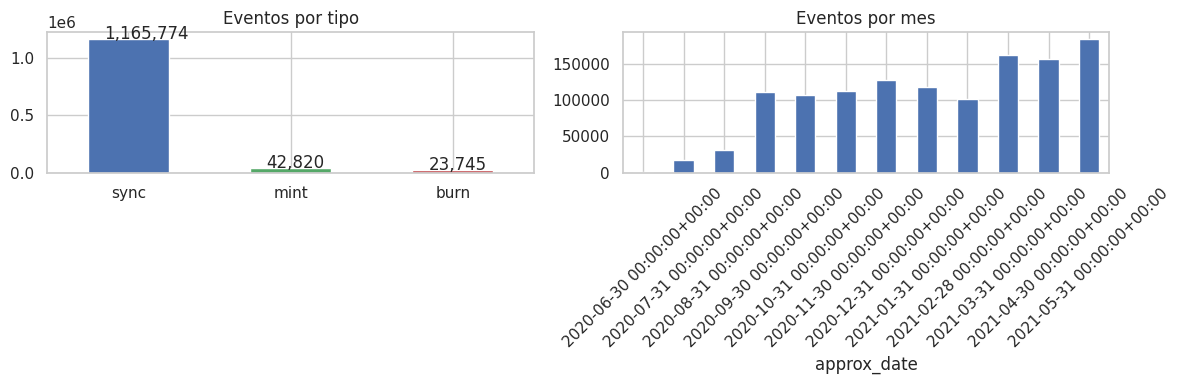

In [6]:
# ── Distribución de eventos por tipo
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

event_counts = df_events['event_type'].value_counts()
event_counts.plot(kind='bar', ax=axes[0], color=['#4C72B0','#55A868','#C44E52'])
axes[0].set_title('Eventos por tipo')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=0)
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():,.0f}', (p.get_x()+0.1, p.get_height()+100))

# Eventos por mes
df_events['block_number'] = pd.to_numeric(df_events['block_number'], errors='coerce')
ETH_REF_BLOCK = 10_000_000
ETH_REF_TS    = pd.Timestamp('2020-06-11', tz='UTC')
df_events['approx_date'] = ETH_REF_TS + pd.to_timedelta(
    (df_events['block_number'] - ETH_REF_BLOCK) * 13.2, unit='s'
)
events_by_month = df_events.set_index('approx_date').resample('ME')['event_type'].count()
events_by_month.plot(kind='bar', ax=axes[1], color='#4C72B0')
axes[1].set_title('Eventos por mes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('reports/eventos_distribucion.png', dpi=100)
plt.show()

In [7]:
# ── Análisis de transfers: top wallets por volumen
df_transfers['value'] = pd.to_numeric(df_transfers.get('value', df_transfers.get('value_hex', 0)), errors='coerce').fillna(0)

top_senders = (
    df_transfers.groupby('from_address')['value']
    .sum().sort_values(ascending=False).head(10)
)
print('Top 10 wallets por volumen enviado:')
print(top_senders.to_string())

Top 10 wallets por volumen enviado:
from_address
0x0000000000000000000000000000000000000000   1000000015713312231789464112651426712256512.000000
0x1964b39279625989ef14697a76b730718b9ee6ed            4353847499896217104062510306164736.000000
0xbb2e11998bf694d745b35aa1a00222452024efbf            1759353065452377615452947408224256.000000
0x7a250d5630b4cf539739df2c5dacb4c659f2488d            1479765519245565661544290965258240.000000
0x798de3403b949bffde1d799d77345642967c5c70            1408341225736259088410639350104064.000000
0xa4ed4cfcf8058d48cf5f4bf6c6d36f082f0cf0b8             999999999999999945575230987042816.000000
0x0d3004007682f59d52bc57cd677c2537c4637af0             999500000000000034089168850124800.000000
0x78de41031c60bde03d47aed04f764669e65fa35e             989694069828253209805875075612672.000000
0x61e7e02685bf139df8b6b5b3f927f4d31feb9cef             981916724889527148991967135793152.000000
0xe85740d4b34f727e8cbc9d676d253a4fd736a239             98000000000000002736823168978124

---
## Panel 3 — Feature Engineering y Heurísticas de Labeling

### Conceptos clave

**`WINDOW = 6646 bloques ≈ 24 horas`**  
Los patrones de rug pull se empiezan a ver a partir de las ~20 horas de creado el pool. Evaluamos las features exactamente 24h después del primer SYNC del pool.

**`tx_curve` (HHI — Herfindahl-Hirschman Index)**  
Mide la concentración de tokens en pocas wallets. Un valor cercano a 1 indica que una sola wallet controla casi todo el supply — señal clásica de rug pull.

**Tipos de fraude detectados:**
- `liquidity_stealing`: el LP retira toda la liquidez de golpe (`liq_mdd = -1.0`, sin recuperación)
- `dumping`: el creador vende todos sus tokens hundiendo el precio (`price_mdd ∈ [-1.0, -0.9]`, sin recuperación)

**Convención de labels:**
- `label = 0` → fraude (rug pull)
- `label = 1` → legítimo

In [8]:
# ── 3.1 Funciones de features

def get_pool_features(token_address, df_pools, df_events, eval_block):
    """Features del pool: reservas, precio y liquidez al momento de evaluación."""
    pool_info = df_pools[df_pools['token_address'] == token_address].iloc[0]
    pair      = pool_info['pair_address']
    weth_pos  = 0 if pool_info['weth_is_token0'] else 1
    token_pos = 1 - weth_pos
    decimals  = pool_info[f'token{token_pos}_decimals']

    syncs = df_events[
        (df_events['pair_address'] == pair) &
        (df_events['event_type']   == 'sync') &
        (df_events['block_number'] <  eval_block)
    ].sort_values('block_number')

    if len(syncs) < 2:
        return {}

    weth_r  = syncs[f'amount{weth_pos}_or_reserve{weth_pos}_hex'].apply(lambda x: int(x, 16) / 1e18)
    token_r = syncs[f'amount{token_pos}_or_reserve{token_pos}_hex'].apply(lambda x: int(x, 16) / 10**decimals)

    valid   = (weth_r > 0) & (token_r > 0)
    weth_r  = weth_r[valid].values
    token_r = token_r[valid].values

    if len(weth_r) < 2:
        return {}

    return {
        'n_syncs'  : len(syncs),
        'WETH'     : weth_r[-1],
        'prices'   : weth_r[-1] / token_r[-1],
        'liquidity': weth_r[-1] * token_r[-1],
    }


def get_transfer_features(token_address, df_transfers, eval_block):
    """Actividad de transfers: volumen y diversidad de wallets."""
    t = df_transfers[
        (df_transfers['token_address'] == token_address) &
        (df_transfers['block_number']  <  eval_block)
    ]
    n_unique = len(set(t['from_address'].tolist() + t['to_address'].tolist()))
    return {
        'num_transactions'  : len(t),
        'n_unique_addresses': n_unique,
    }


def get_curve(token_address, df_transfers, eval_block):
    """
    HHI (Herfindahl-Hirschman Index) de concentración del token.
    tx_curve ≈ 1.0 → un solo holder controla todo el supply = señal de fraude.
    """
    t = df_transfers[
        (df_transfers['token_address'] == token_address) &
        (df_transfers['block_number']  <  eval_block)
    ].sort_values('block_number')

    balances     = defaultdict(float)
    total_supply = 0.0

    for _, row in t.iterrows():
        from_ = row['from_address']
        to_   = row['to_address']
        value = float(row['value'])
        balances[from_] -= value
        balances[to_]   += value
        if from_ == ETH_ADDRESS:
            total_supply += value
            balances[from_] = 0
        if to_ == ETH_ADDRESS:
            total_supply -= value
            balances[to_]  = 0

    if total_supply == 0:
        return {'tx_curve': 1.0}

    hhi = sum(
        (v / total_supply) ** 2
        for addr, v in balances.items()
        if addr not in [ETH_ADDRESS, DEAD_ADDRESS]
    )
    return {'tx_curve': hhi}


def get_lp_features(token_address, eval_block, df_pools, df_events, df_metadata):
    """Features de proveedor de liquidez: mints, burns y diferencia de creación."""
    pool_info            = df_pools[df_pools['token_address'] == token_address].iloc[0]
    pair                 = pool_info['pair_address']
    pool_creation_block  = pool_info['block_number']
    token_creation_block = df_metadata[
        df_metadata['token_address'] == token_address
    ]['token_creation_block'].iloc[0]

    lp = df_events[
        (df_events['pair_address'] == pair) &
        (df_events['block_number'] <  eval_block)
    ]
    return {
        'mints'                : len(lp[lp['event_type'] == 'mint']),
        'burns'                : len(lp[lp['event_type'] == 'burn']),
        'difference_token_pool': pool_creation_block - token_creation_block,
    }


def compute_features(token_address, df_pools, df_events, df_transfers, df_metadata):
    """Función principal: computa todas las features para un token dado."""
    pool_info        = df_pools[df_pools['token_address'] == token_address].iloc[0]
    pair             = pool_info['pair_address']
    first_sync_block = df_events[
        (df_events['pair_address'] == pair) &
        (df_events['event_type']   == 'sync')
    ]['block_number'].min()

    eval_block = first_sync_block + WINDOW

    features = {}
    features.update(get_pool_features(token_address, df_pools, df_events, eval_block))
    features.update(get_transfer_features(token_address, df_transfers, eval_block))
    features.update(get_curve(token_address, df_transfers, eval_block))
    features.update(get_lp_features(token_address, eval_block, df_pools, df_events, df_metadata))
    return features


print('✓ Funciones de features definidas')

✓ Funciones de features definidas


In [9]:
# ── 3.2 Heurísticas de labeling

def compute_drawdown(series):
    """Máximo drawdown de una serie de precios o liquidez."""
    running_max = np.maximum.accumulate(series)
    valley_idx  = np.argmax(running_max - series)
    peak_idx    = np.argmax(series[:valley_idx]) if valley_idx > 0 else 0
    peak_val    = series[peak_idx]
    valley_val  = series[valley_idx]
    if peak_val == 0:
        return 0, peak_idx, valley_idx
    return (valley_val - peak_val) / peak_val, peak_idx, valley_idx


def compute_recovery(series, peak_idx, valley_idx):
    """Porcentaje de recuperación después del drawdown."""
    peak_val   = series[peak_idx]
    valley_val = series[valley_idx]
    drop = peak_val - valley_val
    if drop == 0:
        return 0
    return (series[-1] - valley_val) / drop


def extract_label_features(token_address, df_pools, df_events, blockstudy):
    """Extrae features de drawdown y recuperación para asignar labels."""
    pool_info = df_pools[df_pools['token_address'] == token_address].iloc[0]
    pair      = pool_info['pair_address']
    weth_pos  = 0 if pool_info['weth_is_token0'] else 1
    token_pos = 1 - weth_pos
    decimals  = pool_info[f'token{token_pos}_decimals']

    syncs = df_events[
        (df_events['pair_address'] == pair) &
        (df_events['event_type']   == 'sync')
    ].sort_values('block_number')

    if len(syncs) < 5:
        return None

    weth_r  = syncs[f'amount{weth_pos}_or_reserve{weth_pos}_hex'].apply(lambda x: int(x, 16) / 1e18).values
    token_r = syncs[f'amount{token_pos}_or_reserve{token_pos}_hex'].apply(lambda x: int(x, 16) / 10**decimals).values
    blocks  = syncs['block_number'].values

    valid   = (weth_r > 0) & (token_r > 0)
    blocks  = blocks[valid]; weth_r = weth_r[valid]; token_r = token_r[valid]

    if len(blocks) < 5:
        return None

    liquidity = weth_r * token_r
    prices    = weth_r / token_r

    liq_mdd,   liq_peak,   liq_valley   = compute_drawdown(liquidity)
    liq_rc                               = compute_recovery(liquidity, liq_peak, liq_valley)
    price_mdd, price_peak, price_valley  = compute_drawdown(prices)
    price_rc                             = compute_recovery(prices, price_peak, price_valley)

    return {
        'token_address': token_address,
        'pair_address' : pair,
        'inactive'     : int(blockstudy - blocks[-1] > INACTIVITY),
        'late_creation': int(blockstudy - blocks[0]  < INACTIVITY),
        'liq_mdd'      : liq_mdd,
        'liq_rc'       : liq_rc,
        'price_mdd'    : price_mdd,
        'price_rc'     : price_rc,
    }


def assign_labels(df_label_features, inactive_transfers):
    """Asigna label=0 (fraude) según reglas heurísticas."""
    df = df_label_features.copy()
    df['transfer_inactive'] = inactive_transfers
    df['fully_inactive']    = (df['inactive'] == 1) & (df['transfer_inactive'] == 1)

    eligible = df[(df['fully_inactive']) & (df['late_creation'] == 0)]
    records  = []

    # Tipo 1: Liquidity Stealing — LP retira toda la liquidez sin recuperación
    for token in eligible[
        (eligible['liq_mdd'] == -1.0) & (eligible['liq_rc'] <= 0.2)
    ].index:
        records.append({'token_address': token,
                        'pair_address' : df.loc[token, 'pair_address'],
                        'label': 0, 'fraud_type': 'liquidity_stealing'})

    # Tipo 2: Dumping — creador vende todos sus tokens hundiendo el precio
    for token in eligible[
        (eligible['liq_mdd'] == 0) &
        (eligible['price_mdd'].between(-1.0, -0.9)) &
        (eligible['price_rc'].between(0, 0.01))
    ].index:
        records.append({'token_address': token,
                        'pair_address' : df.loc[token, 'pair_address'],
                        'label': 0, 'fraud_type': 'dumping'})

    return pd.DataFrame(records)


def build_labels(df_pools, df_events, df_transfers, blockstudy):
    """Pipeline completo de labeling sobre todos los tokens."""
    label_features = []
    for token in df_pools['token_address']:
        result = extract_label_features(token, df_pools, df_events, blockstudy)
        if result:
            label_features.append(result)

    df_lf = pd.DataFrame(label_features).set_index('token_address')

    inactive_transfers = (
        blockstudy - df_transfers.groupby('token_address')['block_number'].max() > INACTIVITY
    ).astype(int)

    return assign_labels(df_lf, inactive_transfers)


print('✓ Heurísticas de labeling definidas')

✓ Heurísticas de labeling definidas


---
## Panel 4 — Construcción del Dataset

In [10]:
# ── 4.1 Labeling
print('Construyendo labels...')
df_labels = build_labels(df_pools, df_events, df_transfers, BLOCKSTUDY)

print(f'Tokens con fraude detectado: {len(df_labels)}')
print(df_labels['fraud_type'].value_counts())

# Todos los tokens parten como legítimos (label=1), luego se sobreescriben los fraudulentos
df_all_labels = df_pools[['token_address', 'pair_address']].copy()
df_all_labels['label']      = 1
df_all_labels['fraud_type'] = 'none'

fraud_idx = df_all_labels['token_address'].isin(df_labels['token_address'])
df_all_labels.loc[fraud_idx, 'label']      = 0
df_all_labels.loc[fraud_idx, 'fraud_type'] = df_all_labels.loc[fraud_idx, 'token_address'].map(
    df_labels.set_index('token_address')['fraud_type']
)

print(f'\nDistribución de labels:')
print(df_all_labels['label'].value_counts())
print(f'  Tasa de fraude: {(df_all_labels["label"]==0).mean():.1%}')

Construyendo labels...
Tokens con fraude detectado: 412
fraud_type
liquidity_stealing    396
dumping                16
Name: count, dtype: int64

Distribución de labels:
label
0    412
1    205
Name: count, dtype: int64
  Tasa de fraude: 66.8%


In [11]:
# ── 4.2 Feature engineering
print('Calculando features (puede tardar unos minutos)...')

feature_list = []
errors = []
for i, token in enumerate(df_all_labels['token_address']):
    if i % 100 == 0:
        print(f'  {i}/{len(df_all_labels)}...')
    try:
        f = compute_features(token, df_pools, df_events, df_transfers, df_metadata)
        if f:
            f['token_address'] = token
            feature_list.append(f)
    except Exception as e:
        errors.append({'token': token, 'error': str(e)})

df_features = pd.DataFrame(feature_list).set_index('token_address')

if errors:
    print(f'!Tokens sin features¡: {len(errors)}')

print(f'✓ Features calculadas para {len(df_features)} tokens')
print(df_features.describe().T[['count','mean','std','min','max']])

Calculando features (puede tardar unos minutos)...
  0/617...
  100/617...
  200/617...
  300/617...
  400/617...
  500/617...
  600/617...
✓ Features calculadas para 617 tokens
                           count                   mean  \
n_syncs               607.000000             166.993410   
WETH                  607.000000              57.830083   
prices                607.000000 506459213165653.312500   
liquidity             607.000000  12981173611022.978516   
num_transactions      617.000000             802.047002   
n_unique_addresses    617.000000             217.743922   
tx_curve              617.000000      4486499684.220627   
mints                 617.000000               4.225284   
burns                 617.000000               1.252836   
difference_token_pool 617.000000          260687.254457   

                                          std      min  \
n_syncs                            696.200343 2.000000   
WETH                               467.353420 0.000000  

In [12]:
# ── 4.3 Dataset final
df_dataset = df_features.join(
    df_all_labels.set_index('token_address')[['label', 'fraud_type']], how='inner'
)

# Descartar tokens sin features suficientes a las 24h del pool
df_dataset = df_dataset.dropna(subset=['n_syncs', 'WETH', 'prices', 'liquidity'])

print(f'Dataset final: {df_dataset.shape}')
print(df_dataset['label'].value_counts())
print(f'  label=0 (fraude)   : {(df_dataset["label"]==0).sum()}')
print(f'  label=1 (legítimo) : {(df_dataset["label"]==1).sum()}')
print(f'  Tasa desbalanceo   : {(df_dataset["label"]==0).mean():.1%}')
df_dataset.head()

Dataset final: (607, 12)
label
0    409
1    198
Name: count, dtype: int64
  label=0 (fraude)   : 409
  label=1 (legítimo) : 198
  Tasa desbalanceo   : 67.4%


,n_syncs,WETH,prices,liquidity,num_transactions,n_unique_addresses,tx_curve,mints,burns,difference_token_pool,label,fraud_type
token_address,,,,,,,,,,,,
0xdd974d5c2e2928dea5f71b9825b8b646686bd200,56.000000,96.592531,0.003050,3058709.771430,1155,729,1.000000,16,0,5827049,1,none
0xa9fbb83a2689f4ff86339a4b96874d718673b627,10.000000,2.640574,0.000000,127601637.622803,29,21,1.000000,3,0,249969,1,none
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,85.000000,394.294949,45.042764,3451.575611,941,234,1.000000,29,1,3324813,1,none
0x1beef31946fbbb40b877a72e4ae04a8d1a5cee06,12.000000,3.283241,0.000001,8746402.353096,55,40,1.000000,5,0,5017619,1,none
0x08d967bb0134f2d07f7cfb6e246680c53927dd30,31.000000,52.262004,0.000815,3350224.486523,64,31,1.000000,3,0,1485099,1,none


In [14]:
# ── 4.4 Visualización del dataset
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, feat in enumerate(FEATURES):
    for label, color, name in [(0, '#C44E52', 'Fraude'), (1, '#4C72B0', 'Legítimo')]:
        data = df_dataset[df_dataset['label'] == label][feat].dropna()
        # Escala log si el rango es muy amplio
        if data.max() > 1e6:
            data = np.log1p(data)
            axes[i].set_xlabel(f'log1p({feat})')
        axes[i].hist(data, bins=30, alpha=0.6, color=color, label=name, density=True)
    axes[i].set_title(feat)
    axes[i].legend(fontsize=7)

plt.suptitle('Distribución de features por label', y=1.01)
plt.tight_layout()
plt.savefig('reports/features_distribucion.png', dpi=100)
plt.show()

In [15]:
# ── 4.5 Correlaciones
plt.figure(figsize=(10, 8))
corr = df_dataset[FEATURES + ['label']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlaciones')
plt.tight_layout()
plt.savefig('reports/correlaciones.png', dpi=100)
plt.show()

In [13]:
# ── 4.6 Split train/test
X = df_dataset[FEATURES]
y = df_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Ratio para corregir desbalanceo en modelos basados en árboles
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f'Train : {X_train.shape} | label 0: {(y_train==0).sum()} | label 1: {(y_train==1).sum()}')
print(f'Test  : {X_test.shape}  | label 0: {(y_test==0).sum()}  | label 1: {(y_test==1).sum()}')
print(f'scale_pos_weight (fraude/legítimo): {scale_pos_weight:.2f}')

Train : (485, 10) | label 0: 327 | label 1: 158
Test  : (122, 10)  | label 0: 82  | label 1: 40
scale_pos_weight (fraude/legítimo): 2.07


---
## Panel 5 — Configuración de MLflow

In [14]:
mlflow.set_tracking_uri(MLFLOW_URI)

# Crear experimento si no existe
EXPERIMENT_NAME = 'rug-pull-detection'
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    mlflow.create_experiment(
    EXPERIMENT_NAME,
    artifact_location="s3://mlflows3/artifacts"
    )
    print(f'✓ Experimento creado: {EXPERIMENT_NAME}')
else:
    print(f'✓ Experimento existente: {EXPERIMENT_NAME} (id={experiment.experiment_id})')

mlflow.set_experiment(EXPERIMENT_NAME)


def log_common_params(window, blockstudy, train_size, test_size, cv_folds, extra_params):
    """Loggea parámetros comunes a todos los runs."""
    mlflow.log_param('window_blocks', window)
    mlflow.log_param('blockstudy',    blockstudy)
    mlflow.log_param('train_size',    train_size)
    mlflow.log_param('test_size',     test_size)
    mlflow.log_param('cv_folds',      cv_folds)
    mlflow.log_param('features',      ','.join(FEATURES))
    for k, v in extra_params.items():
        mlflow.log_param(k, v)


def log_metrics_and_plots(y_test, y_pred, y_proba, cv_aucs, model_name):
    """Loggea métricas, classification report y confusion matrix."""
    auc = roc_auc_score(y_test, y_proba)
    f1  = f1_score(y_test, y_pred, average='macro')
    pre = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')

    mlflow.log_metric('cv_auc_mean', cv_aucs.mean())
    mlflow.log_metric('cv_auc_std',  cv_aucs.std())
    mlflow.log_metric('test_auc',    auc)
    mlflow.log_metric('test_f1',     f1)
    mlflow.log_metric('test_precision', pre)
    mlflow.log_metric('test_recall',    rec)

    print(f'CV AUC  : {cv_aucs.mean():.4f} ± {cv_aucs.std():.4f}')
    print(f'Test AUC: {auc:.4f}')
    print(classification_report(y_test, y_pred, target_names=['Fraude', 'Legítimo']))

    # Confusion matrix como artefacto
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=['Fraude', 'Legítimo'],
        cmap='Blues', ax=ax
    )
    ax.set_title(f'{model_name} — Confusion Matrix')
    plt.tight_layout()
    path = f'reports/cm_{model_name.lower().replace(" ","_")}.png'
    plt.savefig(path, dpi=100)
    mlflow.log_figure(fig, os.path.basename(path))
    plt.show()

    return auc


print('✓ MLflow configurado')

✓ Experimento creado: rug-pull-detection
✓ MLflow configurado


---
## Panel 6 — Modelo 1: Random Forest

Baseline robusto, sin hiperparámetros críticos, buena interpretabilidad vía feature importance.

2026/02/25 04:55:09 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



CV AUC  : 0.9492 ± 0.0113
Test AUC: 0.9323
              precision    recall  f1-score   support

      Fraude       0.88      0.89      0.88        82
    Legítimo       0.77      0.75      0.76        40

    accuracy                           0.84       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.84      0.84      0.84       122



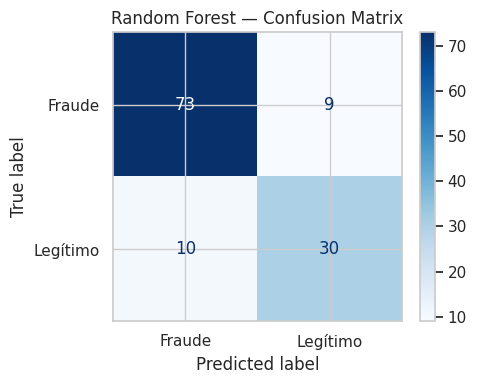

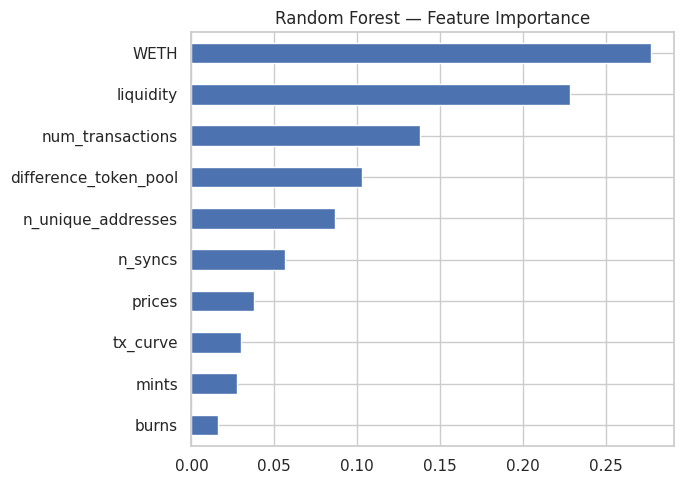

2026/02/25 04:57:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpaqsf45pb/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback.



✓ Random Forest — Test AUC: 0.9323


In [15]:
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

params_rf = {
    'n_estimators'    : 200,
    'max_depth'       : 10,
    'min_samples_leaf': 2,
    'class_weight'    : 'balanced',   # maneja el desbalanceo automáticamente
    'random_state'    : RANDOM_STATE,
    'n_jobs'          : -1,
}

with mlflow.start_run(run_name='random-forest-baseline'):

    log_common_params(WINDOW, BLOCKSTUDY, len(X_train), len(X_test), 5, params_rf)
    mlflow.log_param('model_type', 'RandomForest')

    rf = RandomForestClassifier(**params_rf)

    cv_aucs = cross_val_score(rf, X_train, y_train, cv=CV, scoring='roc_auc')

    rf.fit(X_train, y_train)
    y_pred_rf  = rf.predict(X_test)
    y_proba_rf = rf.predict_proba(X_test)[:, 1]

    auc_rf = log_metrics_and_plots(y_test, y_pred_rf, y_proba_rf, cv_aucs, 'Random Forest')

    # Feature importance
    fi = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=True)
    fig, ax = plt.subplots(figsize=(7, 5))
    fi.plot(kind='barh', ax=ax, color='#4C72B0')
    ax.set_title('Random Forest — Feature Importance')
    plt.tight_layout()
    plt.savefig('reports/fi_rf.png', dpi=100)
    mlflow.log_artifact('reports/fi_rf.png')
    plt.show()

    # Guardar modelo
    mlflow.sklearn.log_model(rf, artifact_path='random_forest')

    print(f'\n✓ Random Forest — Test AUC: {auc_rf:.4f}')

---
## Panel 7 — Modelo 2: XGBoost

Gradient boosting. Usa `scale_pos_weight` para corregir el desbalanceo de clases explícitamente.

CV AUC  : 0.9464 ± 0.0105
Test AUC: 0.9375
              precision    recall  f1-score   support

      Fraude       0.90      0.91      0.91        82
    Legítimo       0.82      0.80      0.81        40

    accuracy                           0.88       122
   macro avg       0.86      0.86      0.86       122
weighted avg       0.88      0.88      0.88       122



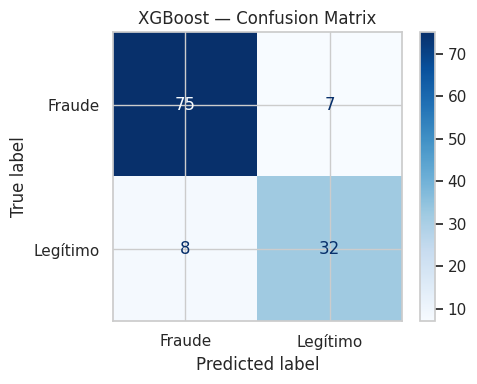

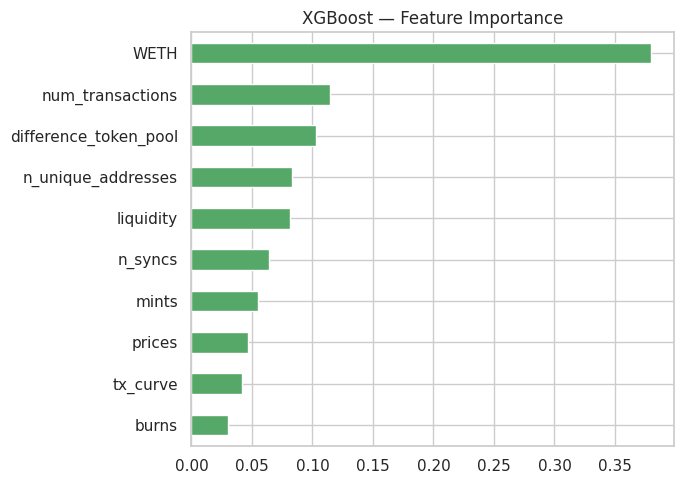

2026/02/25 05:00:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzba9mb4g/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback.



✓ XGBoost — Test AUC: 0.9375


In [16]:
params_xgb = {
    'n_estimators'    : 100,
    'max_depth'       : 6,
    'learning_rate'   : 0.1,
    'subsample'       : 0.8,
    'gamma'           : 1e-2,
    'reg_lambda'      : 1.0,
    'reg_alpha'       : 1e-2,
    'scale_pos_weight': scale_pos_weight,
    'random_state'    : RANDOM_STATE,
    'eval_metric'     : 'auc',
    'verbosity'       : 0,
}

with mlflow.start_run(run_name='xgboost-baseline'):

    log_common_params(WINDOW, BLOCKSTUDY, len(X_train), len(X_test), 5, params_xgb)
    mlflow.log_param('model_type', 'XGBoost')

    xgb_model = xgb.XGBClassifier(**params_xgb)

    cv_aucs = cross_val_score(xgb_model, X_train, y_train, cv=CV, scoring='roc_auc')

    xgb_model.fit(X_train, y_train)
    y_pred_xgb  = xgb_model.predict(X_test)
    y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

    auc_xgb = log_metrics_and_plots(y_test, y_pred_xgb, y_proba_xgb, cv_aucs, 'XGBoost')

    # Feature importance XGBoost
    fi_xgb = pd.Series(xgb_model.feature_importances_, index=FEATURES).sort_values(ascending=True)
    fig, ax = plt.subplots(figsize=(7, 5))
    fi_xgb.plot(kind='barh', ax=ax, color='#55A868')
    ax.set_title('XGBoost — Feature Importance')
    plt.tight_layout()
    plt.savefig('reports/fi_xgb.png', dpi=100)
    mlflow.log_artifact('reports/fi_xgb.png')
    plt.show()

    # Guardar modelo — usar sklearn flavor para evitar el error de logged-models API
    mlflow.sklearn.log_model(xgb_model, artifact_path='xgboost')

    print(f'\n✓ XGBoost — Test AUC: {auc_xgb:.4f}')

---
## Panel 8 — Modelo 3: LightGBM

Gradient boosting más rápido que XGBoost en datasets medianos. Usa `is_unbalance=True` para el desbalanceo.

CV AUC  : 0.9423 ± 0.0085
Test AUC: 0.9473
              precision    recall  f1-score   support

      Fraude       0.89      0.90      0.90        82
    Legítimo       0.79      0.78      0.78        40

    accuracy                           0.86       122
   macro avg       0.84      0.84      0.84       122
weighted avg       0.86      0.86      0.86       122



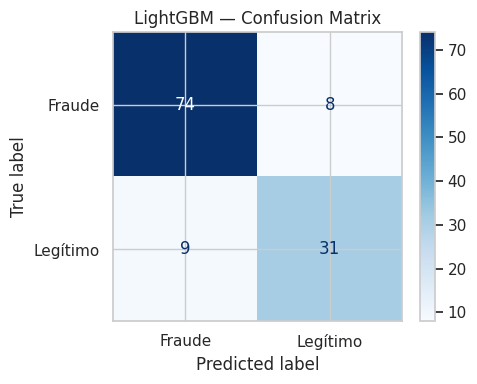

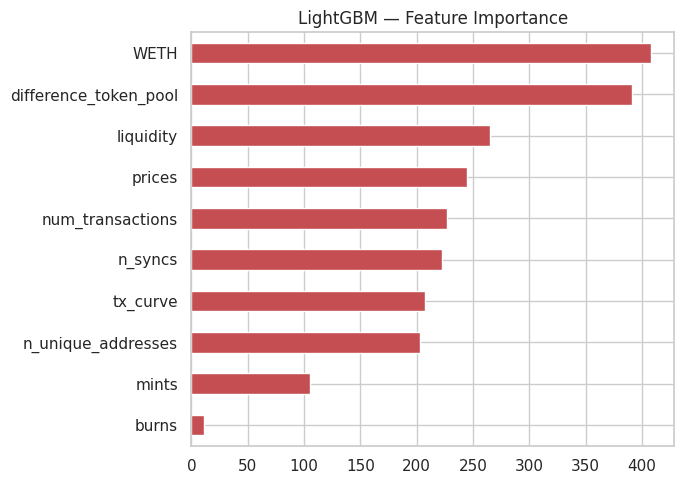

2026/02/25 05:06:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpv4mxu0zn/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback.



✓ LightGBM — Test AUC: 0.9473


In [17]:
params_lgb = {
    'n_estimators'    : 200,
    'max_depth'       : 8,
    'learning_rate'   : 0.05,
    'num_leaves'      : 31,
    'subsample'       : 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha'       : 0.1,
    'reg_lambda'      : 1.0,
    'is_unbalance'    : True,
    'random_state'    : RANDOM_STATE,
    'verbose'         : -1,
}

with mlflow.start_run(run_name='lightgbm-baseline'):

    log_common_params(WINDOW, BLOCKSTUDY, len(X_train), len(X_test), 5, params_lgb)
    mlflow.log_param('model_type', 'LightGBM')

    lgb_model = lgb.LGBMClassifier(**params_lgb)

    cv_aucs = cross_val_score(lgb_model, X_train, y_train, cv=CV, scoring='roc_auc')

    lgb_model.fit(X_train, y_train)
    y_pred_lgb  = lgb_model.predict(X_test)
    y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

    auc_lgb = log_metrics_and_plots(y_test, y_pred_lgb, y_proba_lgb, cv_aucs, 'LightGBM')

    # Feature importance LightGBM
    fi_lgb = pd.Series(lgb_model.feature_importances_, index=FEATURES).sort_values(ascending=True)
    fig, ax = plt.subplots(figsize=(7, 5))
    fi_lgb.plot(kind='barh', ax=ax, color='#C44E52')
    ax.set_title('LightGBM — Feature Importance')
    plt.tight_layout()
    plt.savefig('reports/fi_lgb.png', dpi=100)
    mlflow.log_artifact('reports/fi_lgb.png')
    plt.show()

    mlflow.sklearn.log_model(lgb_model, artifact_path='lightgbm')

    print(f'\n✓ LightGBM — Test AUC: {auc_lgb:.4f}')

---
## Panel 9 — Comparación de modelos

In [18]:
# ── Tabla comparativa ─────────────────────────────────────────────────────────
from sklearn.metrics import roc_curve

results = [
    {'Modelo': 'Random Forest', 'AUC': auc_rf,
     'F1 (macro)': f1_score(y_test, y_pred_rf, average='macro'),
     'Precision (fraude)': precision_score(y_test, y_pred_rf, pos_label=0),
     'Recall (fraude)':    recall_score(y_test, y_pred_rf, pos_label=0)},
    {'Modelo': 'XGBoost',       'AUC': auc_xgb,
     'F1 (macro)': f1_score(y_test, y_pred_xgb, average='macro'),
     'Precision (fraude)': precision_score(y_test, y_pred_xgb, pos_label=0),
     'Recall (fraude)':    recall_score(y_test, y_pred_xgb, pos_label=0)},
    {'Modelo': 'LightGBM',      'AUC': auc_lgb,
     'F1 (macro)': f1_score(y_test, y_pred_lgb, average='macro'),
     'Precision (fraude)': precision_score(y_test, y_pred_lgb, pos_label=0),
     'Recall (fraude)':    recall_score(y_test, y_pred_lgb, pos_label=0)},
]

df_results = pd.DataFrame(results).set_index('Modelo').round(4)
print('── Comparación de modelos ──────────────────────────────')
print(df_results.to_string())
best_model = df_results['AUC'].idxmax()
print(f'\n Mejor modelo por AUC: {best_model} ({df_results.loc[best_model, "AUC"]:.4f})')

── Comparación de modelos ──────────────────────────────
                   AUC  F1 (macro)  Precision (fraude)  Recall (fraude)
Modelo                                                                 
Random Forest 0.932300    0.822200            0.879500         0.890200
XGBoost       0.937500    0.859600            0.903600         0.914600
LightGBM      0.947300    0.840900            0.891600         0.902400

 Mejor modelo por AUC: LightGBM (0.9473)


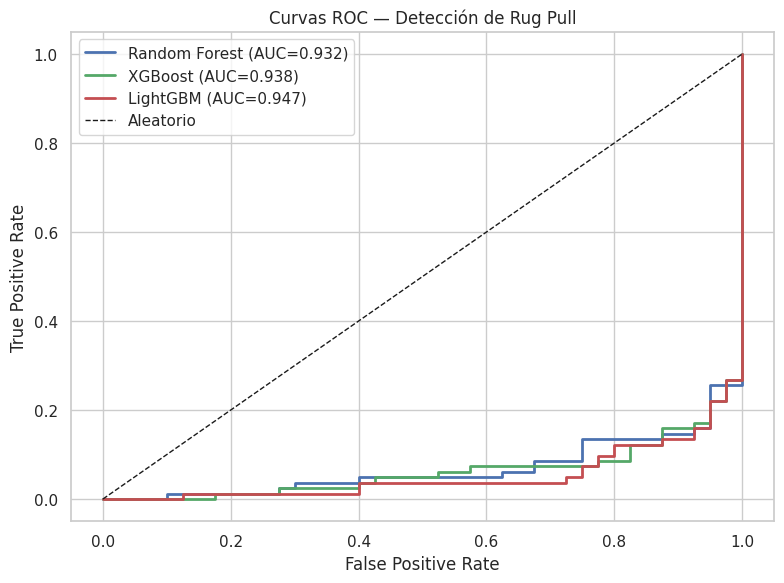

✓ Curvas ROC guardadas


In [19]:
# ── Curvas ROC superpuestas ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

for name, y_proba, color in [
    ('Random Forest', y_proba_rf,  '#4C72B0'),
    ('XGBoost',       y_proba_xgb, '#55A868'),
    ('LightGBM',      y_proba_lgb, '#C44E52'),
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=0)
    auc_val = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.3f})', color=color, lw=2)

ax.plot([0,1],[0,1], 'k--', lw=1, label='Aleatorio')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Curvas ROC — Detección de Rug Pull')
ax.legend()
plt.tight_layout()
plt.savefig('reports/roc_comparacion.png', dpi=100)
plt.show()
print('✓ Curvas ROC guardadas')

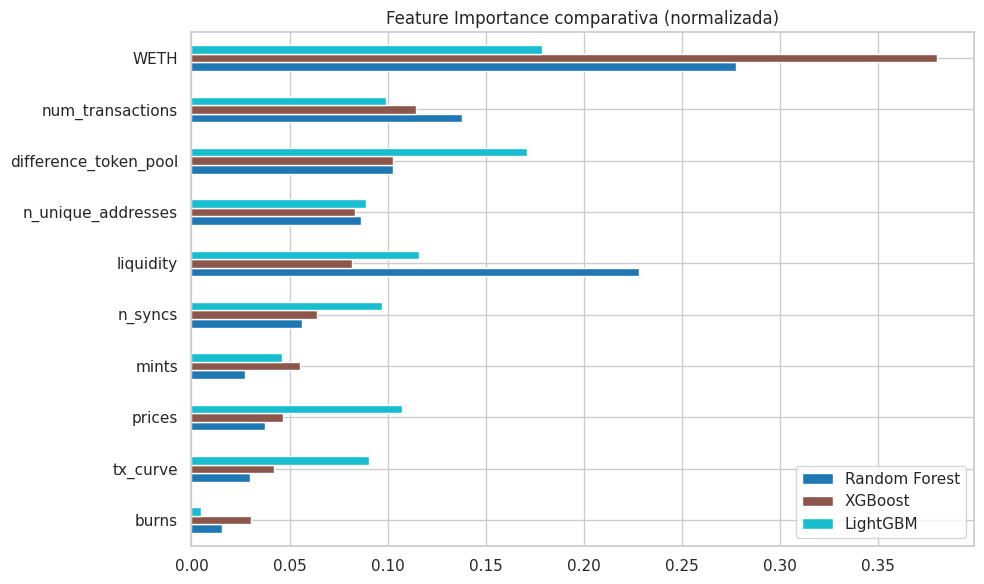


── Features más importantes (promedio entre modelos) ──
WETH                    0.278600
liquidity               0.141900
difference_token_pool   0.125600
num_transactions        0.117300
n_unique_addresses      0.086200
n_syncs                 0.072600
prices                  0.063900
tx_curve                0.054100
mints                   0.042800
burns                   0.017000


In [20]:
# ── Feature importance comparativa ───────────────────────────────────────────
df_fi = pd.DataFrame({
    'Random Forest': rf.feature_importances_,
    'XGBoost'      : xgb_model.feature_importances_,
    'LightGBM'     : lgb_model.feature_importances_ / lgb_model.feature_importances_.sum(),
}, index=FEATURES)

df_fi.sort_values('XGBoost').plot(
    kind='barh', figsize=(10, 6), colormap='tab10'
)
plt.title('Feature Importance comparativa (normalizada)')
plt.tight_layout()
plt.savefig('reports/fi_comparacion.png', dpi=100)
plt.show()

print('\n── Features más importantes (promedio entre modelos) ──')
print(df_fi.mean(axis=1).sort_values(ascending=False).round(4).to_string())

In [21]:
# ── Guardar dataset final como artefacto en MLflow ───────────────────────────
dataset_path = 'reports/dataset_labeled.csv'
df_dataset.reset_index().to_csv(dataset_path, index=False)

with mlflow.start_run(run_name='dataset-final'):
    mlflow.log_artifact(dataset_path)
    mlflow.log_artifact('reports/roc_comparacion.png')
    mlflow.log_artifact('reports/fi_comparacion.png')
    mlflow.log_artifact('reports/features_distribucion.png')
    mlflow.log_artifact('reports/correlaciones.png')
    mlflow.log_metric('n_samples',      len(df_dataset))
    mlflow.log_metric('n_fraud',        (df_dataset['label']==0).sum())
    mlflow.log_metric('n_legit',        (df_dataset['label']==1).sum())
    mlflow.log_metric('fraud_rate',     round((df_dataset['label']==0).mean(), 4))
    mlflow.log_param('features',        ','.join(FEATURES))
    mlflow.log_param('fraud_types',     'liquidity_stealing,dumping')

print(f'✓ Dataset y artefactos registrados en MLflow')
print(f'  Revisa los resultados en: {MLFLOW_URI}')

✓ Dataset y artefactos registrados en MLflow
  Revisa los resultados en: http://mlflow:5000
